In [1]:
pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install tld

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412 kB 4.7 MB/s 


## Importing libraries

In [3]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from tld import get_tld, is_tld

##  Loading Dataset

In [4]:
data = pd.read_csv("malicious_phish.csv")
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651195 entries, 0 to 651194
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651195 non-null  object
 1   type    651195 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [6]:
data.isnull().sum()

url     0
type    0
dtype: int64

In [7]:
data.tail()

,url,type
651190,xbox360.ign.com/objects/850/850402.html,phishing
651191,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651192,www.gamespot.com/xbox360/action/deadspace/,phishing
651193,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing
651194,www.angelfire.com/goth/devilmaycrytonite/,phishing


In [8]:
data = data.dropna()
data.isnull().sum()

url     0
type    0
dtype: int64

In [9]:
count = data.type.value_counts()
count

benign        428107
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

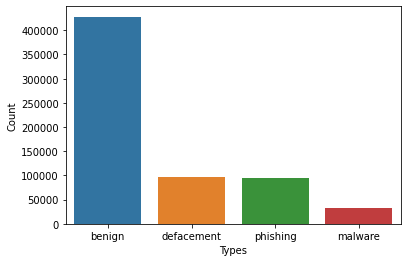

In [10]:
sns.barplot(x=count.index, y=count)
plt.xlabel('Types')
plt.ylabel('Count');

**first have to omit the (www.) from the URL which is in fact a sub domain in itself.**

In [11]:
data['url'] = data['url'].replace('www.', '', regex=True)
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [12]:
rem = {"Category": {"benign": 0, "defacement": 1, "phishing":2, "malware":3}}
data['Category'] = data['type']
data = data.replace(rem)
data

,url,type,Category
0,br-icloud.com.br,phishing,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1
...,...,...,...
651190,xbox360.ign.com/objects/850/850402.html,phishing,2
651191,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,2
651192,gamespot.com/xbox360/action/deadspace/,phishing,2
651193,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,2


## Feature Extraction

In [13]:
data['url_len'] = data['url'].apply(lambda x: len(str(x)))
data.head()

,url,type,Category,url_len
0,br-icloud.com.br,phishing,2,16
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235


In [14]:
#res.parsed_url :-
# SplitResult(
#     scheme='http',
#     netloc='some.subdomain.google.co.uk',
#     path='',
#     query='',
#     fragment=''
# )  
###  more info :- https://pypi.org/project/tld/

def process_tld(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

In [15]:
data['domain'] = data['url'].apply(lambda i: process_tld(i))
data.head()

,url,type,Category,url_len,domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net


In [16]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','/','//','http','https']
for a in feature:
    data[a] = data['url'].apply(lambda i: i.count(a))
    
from urllib.parse import urlparse
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')
data['count_dir'] = data['url'].apply(lambda i: no_of_dir(i))

#Length of URL
data['url_length'] = data['url'].apply(lambda i: len(str(i)))
#Hostname Length
data['hostname_length'] = data['url'].apply(lambda i: len(urlparse(i).netloc))
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
data['sus_url'] = data['url'].apply(lambda i: suspicious_words(i))
#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

data['fd_length'] = data['url'].apply(lambda i: fd_length(i))

#Length of Top Level Domain
data['tld'] = data['url'].apply(lambda i: get_tld(i,fail_silently=True))
def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

data['tld_length'] = data['tld'].apply(lambda i: tld_length(i))


data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,//,http,https,count_dir,url_length,hostname_length,sus_url,fd_length,tld,tld_length
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,16,0,0,0,None,-1
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,0,2,35,0,0,5,None,-1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,3,31,0,0,7,None,-1
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,1,1,0,1,84,17,0,9,be,2
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,1,1,0,1,235,23,0,9,net,3


**classifiying abnormal url**

In [17]:
# how urlparse work : https://www.tutorialspoint.com/urllib-parse-parse-urls-into-components-in-python

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [18]:
data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,http,https,count_dir,url_length,hostname_length,sus_url,fd_length,tld,tld_length,abnormal_url
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,16,0,0,0,None,-1,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,2,35,0,0,5,None,-1,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,3,31,0,0,7,None,-1,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,1,0,1,84,17,0,9,be,2,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,1,0,1,235,23,0,9,net,3,1


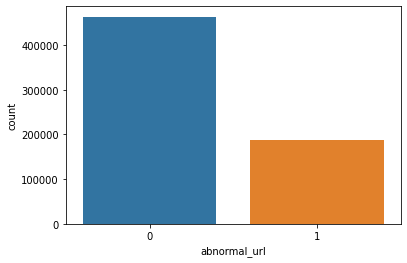

In [19]:
sns.countplot(x='abnormal_url', data=data);

In [20]:
def httpSecure(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [21]:
data['https'] = data['url'].apply(lambda i: httpSecure(i))
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,http,https,count_dir,url_length,hostname_length,sus_url,fd_length,tld,tld_length,abnormal_url
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,16,0,0,0,None,-1,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,2,35,0,0,5,None,-1,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,3,31,0,0,7,None,-1,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,1,0,1,84,17,0,9,be,2,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,1,0,1,235,23,0,9,net,3,1


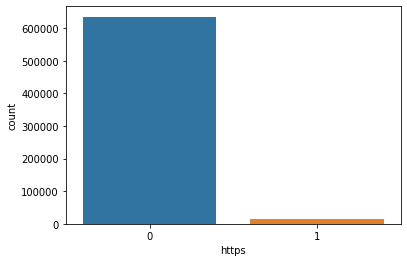

In [22]:
sns.countplot(x='https', data=data);

**Counting the number of digit characters in a URL**


In [23]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [24]:
data['digits']= data['url'].apply(lambda i: digit_count(i))
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,https,count_dir,url_length,hostname_length,sus_url,fd_length,tld,tld_length,abnormal_url,digits
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,16,0,0,0,None,-1,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,2,35,0,0,5,None,-1,0,1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,3,31,0,0,7,None,-1,0,1
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,0,1,84,17,0,9,be,2,1,7
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,1,235,23,0,9,net,3,1,22


**Counting the number of letter characters in a URL**

In [25]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [26]:
data['letters']= data['url'].apply(lambda i: letter_count(i))
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,count_dir,url_length,hostname_length,sus_url,fd_length,tld,tld_length,abnormal_url,digits,letters
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,16,0,0,0,None,-1,0,0,13
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,2,35,0,0,5,None,-1,0,1,29
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,3,31,0,0,7,None,-1,0,1,25
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,1,84,17,0,9,be,2,1,7,60
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,1,235,23,0,9,net,3,1,22,199


**Checking to see whether URL contains a shortening service**

In [27]:
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

In [28]:
data['Shortining_Service'] = data['url'].apply(lambda x: Shortining_Service(x))
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,url_length,hostname_length,sus_url,fd_length,tld,tld_length,abnormal_url,digits,letters,Shortining_Service
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,16,0,0,0,None,-1,0,0,13,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,35,0,0,5,None,-1,0,1,29,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,31,0,0,7,None,-1,0,1,25,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,84,17,0,9,be,2,1,7,60,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,235,23,0,9,net,3,1,22,199,0


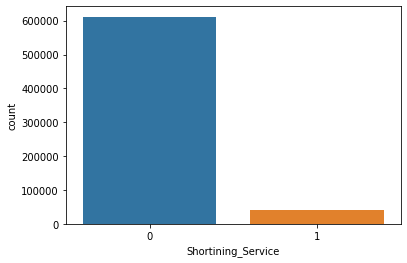

In [29]:
sns.countplot(x='Shortining_Service', data=data);

In [30]:
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

In [31]:
data['having_ip_address'] = data['url'].apply(lambda i: having_ip_address(i))
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,hostname_length,sus_url,fd_length,tld,tld_length,abnormal_url,digits,letters,Shortining_Service,having_ip_address
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,None,-1,0,0,13,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,5,None,-1,0,1,29,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,7,None,-1,0,1,25,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,17,0,9,be,2,1,7,60,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,23,0,9,net,3,1,22,199,0,0


In [32]:
data['having_ip_address'].value_counts()

0    638707
1     12488
Name: having_ip_address, dtype: int64

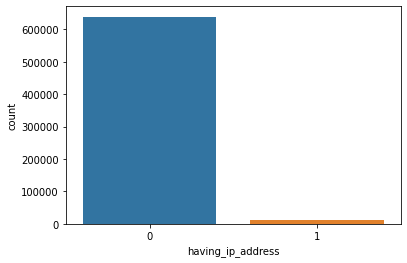

In [33]:
sns.countplot(x='having_ip_address', data=data);

### Heatmap

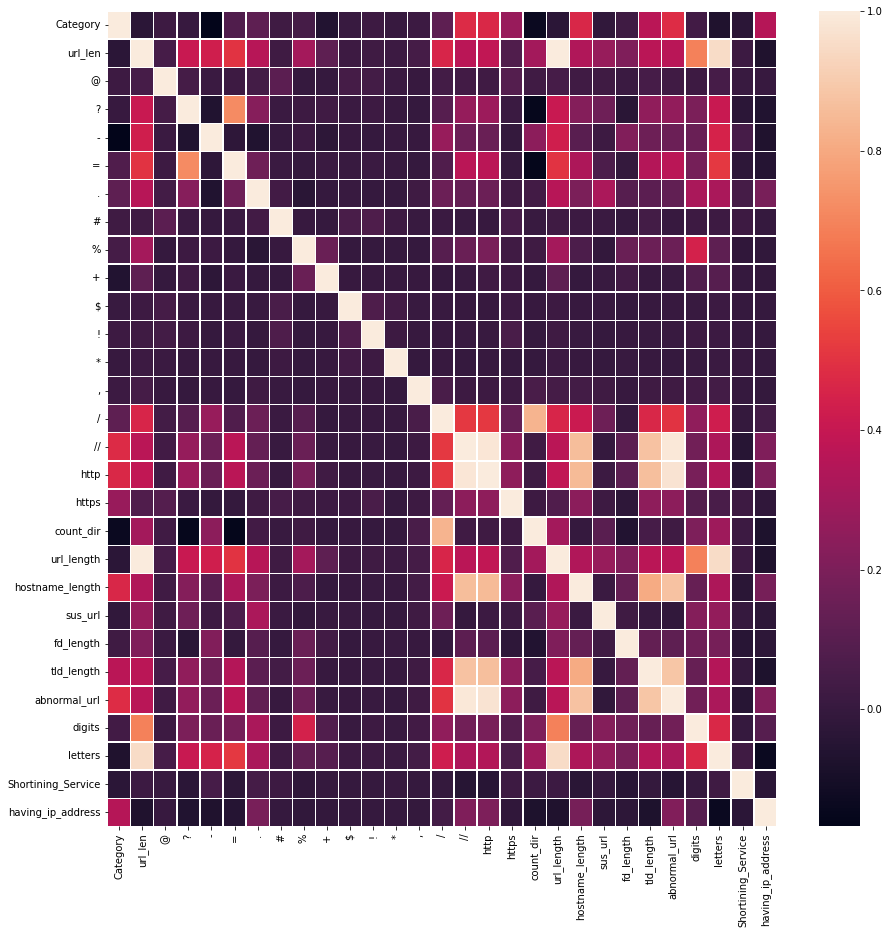

In [34]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), linewidths=.4)

In [36]:
X = data.drop(['url','type','Category','domain','tld'],axis=1)#,'type_code'
y = data['Category']

### Train & Test Split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

### Training models

In [38]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

#############################################
######-Model => <class 'sklearn.tree._classes.DecisionTreeClassifier'> 
Test Accuracy :  92.58%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     85434
           1       0.97      0.98      0.98     19149
           2       0.78      0.70      0.74     19128
           3       0.96      0.94      0.95      6528

    accuracy                           0.93    130239
   macro avg       0.91      0.90      0.90    130239
weighted avg       0.92      0.93      0.92    130239

             Confusion_matrix 


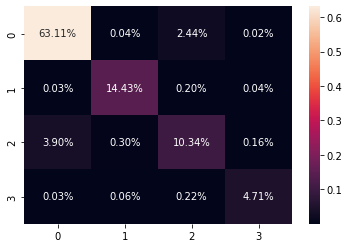

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
Test Accuracy :  93.55%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     85434
           1       0.98      0.99      0.98     19149
           2       0.83      0.72      0.77     19128
           3       0.99      0.94      0.96      6528

    accuracy                           0.94    130239
   macro avg       0.93      0.90      0.92    130239
weighted avg       0.93      0.94      0.93    130239

             Confusion_matrix 


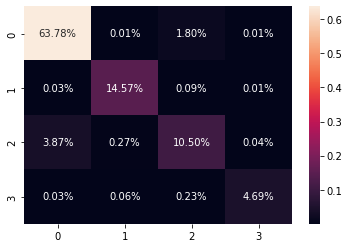

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'> 
Test Accuracy :  36.68%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.90      0.20      0.33     85434
           1       0.82      0.90      0.86     19149
           2       0.27      0.60      0.38     19128
           3       0.04      0.32      0.08      6528

    accuracy                           0.37    130239
   macro avg       0.51      0.50      0.41    130239
weighted avg       0.75      0.37      0.40    130239

             Confusion_matrix 


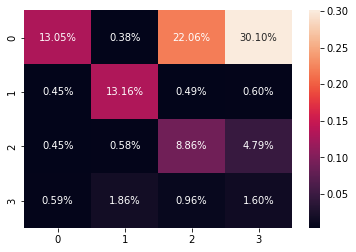

###################- End -###################
#############################################
######-Model => <class 'sklearn.neighbors._classification.KNeighborsClassifier'> 
Test Accuracy :  91.76%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     85434
           1       0.93      0.97      0.95     19149
           2       0.80      0.64      0.71     19128
           3       0.96      0.91      0.93      6528

    accuracy                           0.92    130239
   macro avg       0.90      0.87      0.89    130239
weighted avg       0.91      0.92      0.91    130239

             Confusion_matrix 


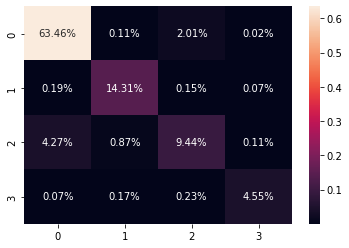

###################- End -###################
#############################################
######-Model => <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'> 
Test Accuracy :  80.63%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.81      0.99      0.90     85434
           1       0.85      0.79      0.82     19149
           2       0.46      0.14      0.21     19128
           3       0.97      0.35      0.51      6528

    accuracy                           0.81    130239
   macro avg       0.77      0.57      0.61    130239
weighted avg       0.78      0.81      0.76    130239

             Confusion_matrix 


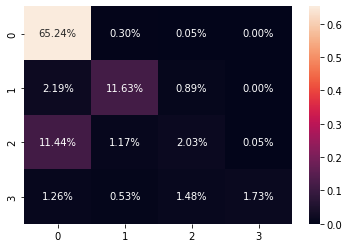

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._forest.ExtraTreesClassifier'> 
Test Accuracy :  93.45%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     85434
           1       0.97      0.99      0.98     19149
           2       0.83      0.71      0.77     19128
           3       0.99      0.94      0.96      6528

    accuracy                           0.93    130239
   macro avg       0.93      0.90      0.92    130239
weighted avg       0.93      0.93      0.93    130239

             Confusion_matrix 


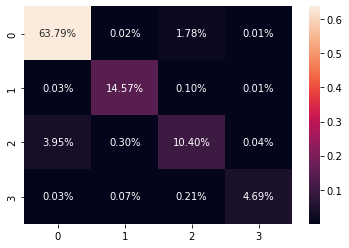

###################- End -###################
#############################################
######-Model => <class 'sklearn.naive_bayes.GaussianNB'> 
Test Accuracy :  79.27%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.85      0.92      0.88     85434
           1       0.67      1.00      0.80     19149
           2       0.69      0.06      0.10     19128
           3       0.62      0.71      0.66      6528

    accuracy                           0.79    130239
   macro avg       0.71      0.67      0.61    130239
weighted avg       0.79      0.79      0.74    130239

             Confusion_matrix 


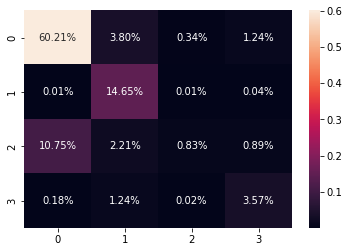

###################- End -###################


In [39]:
models = [DecisionTreeClassifier,RandomForestClassifier,AdaBoostClassifier,KNeighborsClassifier,SGDClassifier,
         ExtraTreesClassifier,GaussianNB]
accuracy_test=[]
for m in models:
    print('#############################################')
    print('######-Model =>\033[07m {} \033[0m'.format(m))
    model_ = m()
    model_.fit(X_train, y_train)
    pred = model_.predict(X_test)
    acc = accuracy_score(pred, y_test)
    accuracy_test.append(acc)
    print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))
    print('\033[01m              Classification_report \033[0m')
    print(classification_report(y_test, pred))
    print('\033[01m             Confusion_matrix \033[0m')
    cf_matrix = confusion_matrix(y_test, pred)
    plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')a
    plt.show()
    print('\033[31m###################- End -###################\033[0m')

## Final report

In [40]:
output = pd.DataFrame({"Model":['Decision Tree Classifier','Random Forest Classifier',
                                'AdaBoost Classifier','KNeighbors Classifier','SGD Classifier',
                                'Extra Trees Classifier','Gaussian NB'],
                      "Accuracy":accuracy_test})
output

,Model,Accuracy
0,Decision Tree Classifier,0.925813
1,Random Forest Classifier,0.935503
2,AdaBoost Classifier,0.366780
3,KNeighbors Classifier,0.917590
4,SGD Classifier,0.806318
5,Extra Trees Classifier,0.934505
6,Gaussian NB,0.792673


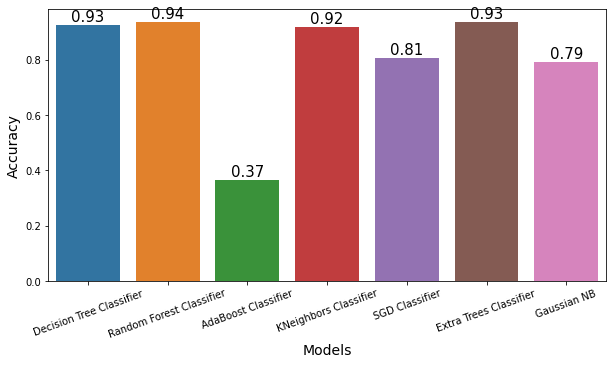

In [41]:
plt.figure(figsize=(10, 5))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.xticks(rotation=20);
plt.ylabel("Accuracy", size=14)
plt.show()